### Imports

In [1]:
from tqdm import tqdm
import random
import sys

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import gymnasium as gym
import gym_mtsim
sys.path.append("C:/Users/WilliamFetzner/Documents/Trading/")
from gym_mtsim_forked.gym_mtsim.data import FOREX_DATA_PATH_TRAIN, FOREX_DATA_PATH_TEST, FOREX_DATA_PATH
from gym_mtsim import OrderType, Timeframe, MtEnv, MtSimulator
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials, STATUS_FAIL
from stable_baselines3 import A2C, PPO
from stable_baselines3.common.callbacks import BaseCallback, EvalCallback
import time
import torch
import pickle
from gym_mtsim_forked.gym_mtsim.data import STOCKS_DATA_PATH

c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment forex-unhedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-hedge-v0 already in registry.
  logger.warn(f"Overriding environment {new_spec.id} already in registry.")
c:\Users\WilliamFetzner\AppData\Local\Programs\Python\Python311\Lib\site-packages\gymnasium\envs\registration.py:694: UserWarning: WARN: Overriding environment stocks-unhedge-v0 alr

# Parameters

In [4]:

# unpack the pickle file and load the data that is in symbols_forex.pkl
with open('C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex.pkl', 'rb') as f:
    symbols = pickle.load(f)
# convert symbols to a pd.dataframe
# symbols[1]['EURUSD']
split = int(len(symbols[1]['EURUSD']) * 0.80)
validation_split = int(len(symbols[1]['EURUSD']) * 0.90)

In [5]:
# get the 2 weeks of the symbols[1]['EURUSD'] dataframe by first finding the max date
# then subtracting 14 days from that date
symbols[1]['EURUSD'].index = pd.to_datetime(symbols[1]['EURUSD'].index)
max_date = symbols[1]['EURUSD'].index.max()

In [6]:
# find the previous friday before max_date
# what is the day of the week of the max_date
max_day_of_week = max_date.dayofweek
# subtract the day of the week from the max_date to get the previous friday
max_friday = max_date - pd.DateOffset(days=max_day_of_week+2)
two_weeks = max_friday - pd.DateOffset(days=14)
one_week = max_friday - pd.DateOffset(days=7)

In [7]:
training_index_slice = symbols[1]['EURUSD'].loc[:one_week, :].index
validation_index_slice = symbols[1]['EURUSD'].loc[one_week:max_friday, :].index

In [8]:
validation_index_slice

DatetimeIndex(['2024-04-08 00:00:00+00:00', '2024-04-08 01:00:00+00:00',
               '2024-04-08 02:00:00+00:00', '2024-04-08 03:00:00+00:00',
               '2024-04-08 04:00:00+00:00', '2024-04-08 05:00:00+00:00',
               '2024-04-08 06:00:00+00:00', '2024-04-08 07:00:00+00:00',
               '2024-04-08 08:00:00+00:00', '2024-04-08 09:00:00+00:00',
               ...
               '2024-04-12 14:00:00+00:00', '2024-04-12 15:00:00+00:00',
               '2024-04-12 16:00:00+00:00', '2024-04-12 17:00:00+00:00',
               '2024-04-12 18:00:00+00:00', '2024-04-12 19:00:00+00:00',
               '2024-04-12 20:00:00+00:00', '2024-04-12 21:00:00+00:00',
               '2024-04-12 22:00:00+00:00', '2024-04-12 23:00:00+00:00'],
              dtype='datetime64[ns, UTC]', name='Time', length=120, freq=None)

### Create Env

In [2]:
sim_train = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

In [9]:
env_train = MtEnv(
    original_simulator=sim_train,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(training_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [14]:
sim_validation = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=FOREX_DATA_PATH
)

env_validation = MtEnv(
    original_simulator=sim_validation,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

### Define Functions

In [20]:
def print_stats(reward_over_episodes, printing_name):
    """  Print Reward  """

    avg_rewards = np.mean(reward_over_episodes)
    min_rewards = np.min(reward_over_episodes)
    max_rewards = np.max(reward_over_episodes)

    print (f'Min. {printing_name}          : {min_rewards:>10.3f}')
    print (f'Avg. {printing_name}          : {avg_rewards:>10.3f}')
    print (f'Max. {printing_name}          : {max_rewards:>10.3f}')

    return min_rewards, avg_rewards, max_rewards

def my_profit_calculation(env_orders, stop_loss):
        # env_orders = env_testing.render()['orders']
        # stop_loss = 0.001

        # normalize the Volume with to have a mean of 1
        mean_value = env_orders['Volume'].mean()

        # Normalize the column to have a mean of 1
        env_orders.loc[:, 'Volume_normalized'] = round((env_orders['Volume'] / mean_value), 2)
        # add a column for when the difference between the Entry Price and the Exit Price is greater than stop_loss
        env_orders.loc[:, 'stoploss_hit'] = np.where((env_orders['Type'].str.strip() == 'Buy') &
                                                        ((env_orders['Entry Price'] - env_orders['Exit Price']) > stop_loss),
                                                        1, np.where((env_orders['Type'].str.strip() == 'Sell') &
                                                                        ((env_orders['Exit Price'] - env_orders['Entry Price']) > stop_loss),
                                                                        1, 0))
        env_orders.loc[:, 'Exit Price'] = np.where((env_orders['Type'].str.strip() == 'Buy') & (env_orders['stoploss_hit'] == 1),
                                                        env_orders['Entry Price'] - stop_loss,
                                                        np.where((env_orders['Type'].str.strip() == 'Sell') & (env_orders['stoploss_hit'] == 1),
                                                                env_orders['Entry Price'] + stop_loss, env_orders['Exit Price']))
        env_orders.loc[:, 'Profit'] = np.where((env_orders['Type'].str.strip() == 'Buy'),
                                                        ((env_orders['Exit Price'] - (env_orders['Fee']/2)) - 
                                                        (env_orders['Entry Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume_normalized'], 
                                                        np.where((env_orders['Type'].str.strip() == 'Sell'),
                                                                ((env_orders['Entry Price'] - (env_orders['Fee']/2)) - 
                                                                (env_orders['Exit Price'] + (env_orders['Fee']/2)))
                                                                * 100_000 * env_orders['Volume_normalized'], np.nan))
        total_reward = env_orders.loc[:, 'Profit'].sum()
        # Calculate Gross Profit
        gross_profit = env_orders.loc[env_orders['Profit'] > 0, 'Profit'].sum()

        # Calculate Gross Loss
        gross_loss = env_orders.loc[env_orders['Profit'] < 0, 'Profit'].abs().sum()

        # Calculate Profit Factor
        profit_factor = gross_profit / gross_loss if gross_loss != 0 else 0

        profit_factor = profit_factor - 1

        return profit_factor, total_reward, env_orders

# ProgressBarCallback for model.learn()
class ProgressBarCallback(BaseCallback):

    def __init__(self, check_freq: int, verbose: int = 1):
        super().__init__(verbose)
        self.check_freq = check_freq

    def _on_training_start(self) -> None:
        """
        This method is called before the first rollout starts.
        """
        self.progress_bar = tqdm(total=self.model._total_timesteps, desc="model.learn()")

    def _on_step(self) -> bool:
        if self.n_calls % self.check_freq == 0:
            self.progress_bar.update(self.check_freq)
        return True
    
    def _on_training_end(self) -> None:
        """
        This event is triggered before exiting the `learn()` method.
        """
        self.progress_bar.close()


In [30]:
# TRAINING + TEST
def train_val_model(model, model_policy, env_tr, env_val, seed, steps_str, lr, gamma_param, entropy, total_learning_timesteps=10_000):
    """
    Trains and validates a model using the Proximal Policy Optimization (PPO) algorithm.

    Args:
        model (object): The model to be trained.
        model_policy (object): The policy used by the model.
        env_tr (object): The training environment.
        env_val (object): The validation environment.
        seed (int): The random seed for reproducibility.
        steps_str (str): A string representing the number of steps.
        window_size_param (int): The window size parameter.
        lr (float): The learning rate.
        gamma_param (float): The gamma parameter.
        entropy (float): The entropy coefficient.
        total_learning_timesteps (int, optional): The total number of learning timesteps. Defaults to 10,000.

    Returns:
        tuple: A tuple containing the reward over validations, orders over validations, and the model dictionary.
    """
    # reproduce training and test
    print('-' * 80)
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)

    #model_dict = {}
    # env_tr.window_size = window_size_param
    print(f'entropy: {entropy}, learning rate: {lr}, gamma: {gamma_param}')
    # eval_callback = EvalCallback(env_tr, log_path='./logs/', eval_freq=1000)
    model = PPO(model_policy, env_tr, verbose=0, ent_coef=entropy, learning_rate=lr)#, gamma=gamma_param, 
    obs_tr, info_tr = env_tr.reset(seed=seed)
    # custom callback for 'progress_bar'
    model.learn(total_timesteps=total_learning_timesteps)#, callback=ProgressBarCallback(100))

    reward_over_validations = []
    orders_over_validations = []
    orders_over_validations_dfs = {}
    profit_over_validations = []

    for episode in range(0, 10):
        obs_val, info_val = env_val.reset(seed=seed)

        total_reward = 0
        done_val = False

        while not done_val:
            action, _states = model.predict(obs_val)
            obs_val, reward_val, terminated_val, truncated_val, info_val = env_val.step(action)
            done_val = terminated_val or truncated_val

            total_reward += reward_val
            if done_val:
                break
        try:
            orders_made_in_episode = env_val.render()['orders']
            order_len = len(orders_made_in_episode)
            total_reward, total_profit, orders_df = my_profit_calculation(orders_made_in_episode, 0.001)
            orders_over_validations_dfs[f'{episode}'] = orders_df
            
        except:
            print('There were not any orders produced by the model')
            order_len = 0        

        reward_over_validations.append(total_reward) 
        profit_over_validations.append(total_profit)   
        orders_over_validations.append(order_len)  


        # if episode % 1 == 0:
        avg_reward = np.mean(reward_over_validations)
        avg_orders = np.mean(orders_over_validations)
        avg_profit = np.mean(profit_over_validations)
        print(f'Episode: {episode}, Avg. Reward: {avg_reward:.3f}, # of orders: {avg_orders:.3f}, avg Profit: {avg_profit:.3f}')
    model.save(f'best_hyperparameters/models_4_27_24/model_{steps_str}.pkl')
    return reward_over_validations, orders_over_validations, orders_over_validations_dfs#, model_dict

## Objective Function

In [17]:
seed = 2024  # random seed
total_num_episodes = 10

# print ("env_name                 :", env_name)
print ("seed                     :", seed)

# INIT matplotlib
plot_settings = {}
plot_data = {'x': [i for i in range(1, total_num_episodes + 1)]}

# learning_timesteps_list_in_K = [25]#, 50, 100]
# learning_timesteps_list_in_K = [50, 250, 500]
# learning_timesteps_list_in_K = [500, 1000, 3000, 5000]

# RL Algorithms: https://stable-baselines3.readthedocs.io/en/master/guide/algos.html

timesteps_models_dict = {}
def objective(params):
    learning_timesteps = 100 #params['learning_timesteps']
    ent_coef = params['ent_coef']
    gamma = params['gamma'] #0.99 #
    learning_rate = params['learning_rate']#0.0003#

    if learning_rate > 0.08:
        print(f'Learning rate too high: {learning_rate}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    if ent_coef > 0.1:
        print(f'Entropy too high: {ent_coef}')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}

    total_learning_timesteps = learning_timesteps * 1000
    step_key = f'{learning_timesteps}K'
    policy_dict = PPO.policy_aliases
    policy = policy_dict.get('MultiInputPolicy')
    class_name = type(PPO).__qualname__
    plot_key = f'{class_name}_rewards_'+step_key
    try:
        rewards, orders = train_val_model(PPO, policy, env_train, env_validation, seed, step_key,  
                                                    learning_rate, gamma, ent_coef, total_learning_timesteps)
    except:
        print(f'''there was an error with those parameters: timesteps: {learning_timesteps}, \n
              ent_coef: {ent_coef}, gamma: {gamma}, learning_rate: {learning_rate}''')
        return {'loss': None, 'status': STATUS_FAIL, 'eval_time': time.time(), 'parameters': params}
    # timesteps_models_dict[step_key] = models_dict
    min_rewards, avg_rewards, max_rewards, = print_stats(rewards, 'Reward')
    print_stats(orders, 'Orders')
    label = f'Avg. {avg_rewards:>7.2f} : {class_name} - {step_key}'
    plot_data[plot_key] = rewards
    plot_settings[plot_key] = {'label': label}
    params['avg_orders'] = np.mean(orders)       

    return {'loss': -avg_rewards, 'status': STATUS_OK, 'eval_time': time.time(), 'parameters': params} 

seed                     : 2024


In [18]:
best_hyperparameters_current_week = pd.read_excel('best_hyperparameter_search_results.xlsx')

0.01683527363887545

In [22]:
parameters = {
    # 'window_size': 10,
    # 'learning_timesteps': 25,
    'ent_coef': best_hyperparameters_current_week.loc[0,'ent_coef'],
    'gamma': best_hyperparameters_current_week.loc[0,'gamma'],
    'learning_rate': best_hyperparameters_current_week.loc[0,'learning_rate']
}
rewards_250, orders_250, orders_df_dict_250 = train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, '250K',  
                                            parameters['learning_rate'], parameters['gamma'], parameters['ent_coef'], 250_000)

--------------------------------------------------------------------------------
entropy: 0.01879460162445175, learning rate: 0.01683527363887545, gamma: 0.99
Episode: 0, Avg. Reward: -0.166, # of orders: 42.000, avg Profit: -224.783
Episode: 1, Avg. Reward: 0.745, # of orders: 41.000, avg Profit: 790.657
Episode: 2, Avg. Reward: 0.264, # of orders: 33.667, avg Profit: 270.732
Episode: 3, Avg. Reward: 0.072, # of orders: 29.250, avg Profit: 141.611
Episode: 4, Avg. Reward: 0.038, # of orders: 29.000, avg Profit: 96.550
Episode: 5, Avg. Reward: 0.283, # of orders: 31.500, avg Profit: 242.613
Episode: 6, Avg. Reward: 0.408, # of orders: 32.714, avg Profit: 394.583
Episode: 7, Avg. Reward: 0.308, # of orders: 31.250, avg Profit: 310.829
Episode: 8, Avg. Reward: 0.220, # of orders: 31.444, avg Profit: 198.966
Episode: 9, Avg. Reward: 0.233, # of orders: 31.700, avg Profit: 212.372


In [28]:
rewards_50, orders_50, orders_df_dict_50 = train_val_model(PPO, 'MultiInputPolicy', env_train, env_validation, seed, '250K',  
                                            parameters['learning_rate'], parameters['gamma'], parameters['ent_coef'], 50_000)

--------------------------------------------------------------------------------
entropy: 0.01879460162445175, learning rate: 0.01683527363887545, gamma: 0.99
Episode: 0, Avg. Reward: 1.530, # of orders: 60.000, avg Profit: 2588.582
Episode: 1, Avg. Reward: 0.709, # of orders: 38.500, avg Profit: 1255.176
Episode: 2, Avg. Reward: 0.578, # of orders: 38.667, avg Profit: 1014.547
Episode: 3, Avg. Reward: 0.714, # of orders: 48.250, avg Profit: 1357.107
Episode: 4, Avg. Reward: 0.390, # of orders: 40.600, avg Profit: 991.873
Episode: 5, Avg. Reward: 0.219, # of orders: 36.500, avg Profit: 739.308
Episode: 6, Avg. Reward: 0.047, # of orders: 32.429, avg Profit: 553.190
Episode: 7, Avg. Reward: -0.027, # of orders: 30.750, avg Profit: 430.696
Episode: 8, Avg. Reward: 0.120, # of orders: 30.333, avg Profit: 549.282
Episode: 9, Avg. Reward: 0.156, # of orders: 32.800, avg Profit: 593.882


In [32]:
orders_df_dict['0'].Profit.sum()

2588.5820506547198

In [73]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
obs_tr, info_tr = env_train.reset(seed=seed)
obs_test, info_test = env_validation.reset(seed=seed)
num_episodes = 1000

total_reward = 0
done_test = False
reward_over_tests = {}
for training in ['', '250K_']:
    rewards = []
    for episode in range(num_episodes):
        obs_test, info_test = env_validation.reset(seed=seed)
        model_ppo = PPO.load(f'best_hyperparameters/models_4_27_24/model_{training}0.pkl', env_train)
        done_test = False
        while not done_test:
            action, _states = model_ppo.predict(obs_test)
            obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation.step(action)
            done_test = terminated_test or truncated_test
            
            total_reward += reward_test
            if done_test:
                break
        try:
            orders_made_in_episode_test = env_validation.render()['orders']
            # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
            order_len = len(orders_made_in_episode_test)
            total_reward, total_profit, orders_df = my_profit_calculation(orders_made_in_episode_test, 0.001)
            rewards.append(total_profit)
        except:
            print('There were not any orders produced by the model')
            order_len = 0
    reward_over_tests[f'{training}_1'] = rewards


In [74]:
timesteps_test_df = pd.DataFrame(reward_over_tests, columns=['_1', '250K__1'])
timesteps_test_df = timesteps_test_df.rename(columns={'_1': '50K', '250K__1': '250K'})
timesteps_test_df

,50K,250K
0,2789.853623,973.773970
1,-549.010170,201.233665
2,-675.027914,-412.323772
3,957.664083,71.128088
4,126.783769,-9.466796
...,...,...
995,363.473200,-287.143426
996,141.808152,2359.754129
997,2322.140014,-90.151761
998,1137.009922,99.644005


In [75]:
# transform the dataframe to be a long dataframe where the columns 50K and 250K are in a column called timesteps and the values are in a second column called values
timesteps_test_df_long = pd.melt(timesteps_test_df, var_name='timesteps', value_name='values')
timesteps_test_df_long


,timesteps,values
0,50K,2789.853623
1,50K,-549.010170
2,50K,-675.027914
3,50K,957.664083
4,50K,126.783769
...,...,...
1995,250K,-287.143426
1996,250K,2359.754129
1997,250K,-90.151761
1998,250K,99.644005


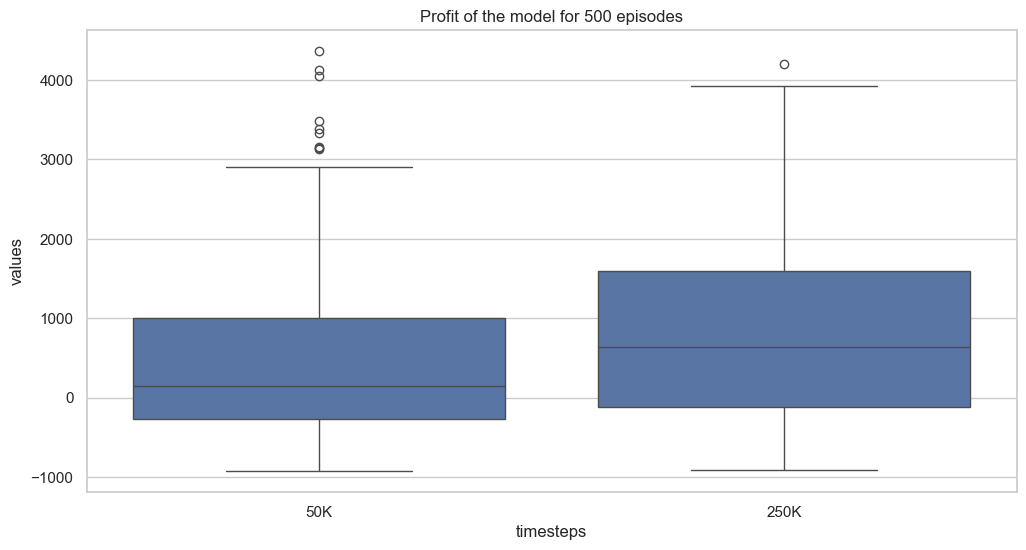

In [76]:

# plot the timesteps_test_df results with the index on the x axis and the values for the columns as the y axis and the column names as the color of the dots
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6)) 
sns.boxplot(x='timesteps', y='values', data=timesteps_test_df_long)
plt.title(f'Profit of the model for {num_episodes} episodes')
plt.show()


In [ ]:
data_path = 'C:/Users/WilliamFetzner/Documents/Trading/gym_mtsim_forked/gym_mtsim/data/symbols_forex_1hr_1_1_24_4_25_24 copy.pkl'
new_data_path = data_path.replace('copy', 'validation')

In [128]:
sim_validation_2 = gym_mtsim.MtSimulator(
    unit='USD',
    balance=200000.,
    leverage=100.,
    stop_out_level=0.2,
    hedge=True,
    symbols_filename=new_data_path
)

env_validation_2 = MtEnv(
    original_simulator=sim_validation_2,
    trading_symbols=['EURUSD'],
    window_size = 10,
    time_points=list(validation_index_slice),
    hold_threshold=0.5,
    close_threshold=0.5,
    fee=lambda symbol: {
        # 'GBPCAD': max(0., np.random.normal(0.0007, 0.00005)),
        'EURUSD': max(0., np.random.normal(0.0001, 0.00003))
        # 'USDJPY': max(0., np.random.normal(0.02, 0.003)),
    }[symbol],
    symbol_max_orders=2,
    multiprocessing_processes=2
)

In [127]:
# with open(data_path, 'rb') as f:
#     symbols = pickle.load(f)
# current_data = symbols[1]['EURUSD']
# current_data.index = pd.to_datetime(current_data.index)
# current_data_validation_index = current_data[env_validation_2.time_points[0]:env_validation_2.time_points[-1]]
# symbols[1]['EURUSD'] = current_data_validation_index
# new_data_path = data_path.replace('copy', 'validation')
# with open(new_data_path , 'wb') as f:
#     pickle.dump(symbols, f)

In [130]:
print(env_validation_2.time_points[-1], sim_validation_2.symbols_data['EURUSD'].index[-1], 
      env_validation_2.time_points[0], sim_validation_2.symbols_data['EURUSD'].index[0])

2024-04-12 23:00:00+00:00 2024-04-12 23:00:00+00:00 2024-04-08 00:00:00+00:00 2024-04-08 00:00:00+00:00


In [131]:
with open(STOCKS_DATA_PATH, 'rb') as f:
    symbols_new = pickle.load(f)
new_data = symbols_new[1]['EURUSD']
new_data

,Open,Close,Low,High,Volume
Time,,,,,
2024-01-02 00:00:00+00:00,1.10437,1.10439,1.10411,1.10451,375
2024-01-02 01:00:00+00:00,1.10441,1.10364,1.10354,1.10447,2207
2024-01-02 02:00:00+00:00,1.10364,1.10381,1.10340,1.10384,2376
2024-01-02 03:00:00+00:00,1.10380,1.10347,1.10340,1.10432,5079
2024-01-02 04:00:00+00:00,1.10348,1.10187,1.10180,1.10358,5520
...,...,...,...,...,...
2024-04-26 19:00:00+00:00,1.06856,1.06945,1.06838,1.06963,1378
2024-04-26 20:00:00+00:00,1.06945,1.06941,1.06931,1.06979,884
2024-04-26 21:00:00+00:00,1.06941,1.07054,1.06936,1.07057,883


In [73]:
def get_latest_data(path_to_data, instrument='EURUSD'):
    with open(path_to_data, 'rb') as f:
        symbols = pickle.load(f)
    current_data = symbols[1][instrument]
    new_data_fil = new_data[new_data.index > max(current_data.index)]
    current_data_new_week_added = pd.concat([current_data, new_data_fil.iloc[[0], :]])
    symbols[1][instrument] = current_data_new_week_added
    # resave the symbols back to a pickle file
    with open(path_to_data, 'wb') as f:
        pickle.dump(symbols, f)

    return len(new_data_fil)
    # sim_validation_2 = gym_mtsim.MtSimulator(
    #     unit='USD',
    #     balance=current_balance,
    #     leverage=100.,
    #     stop_out_level=0.2,
    #     hedge=True,
    #     symbols_filename=path_to_data
    # )
    # env_validation_2 = MtEnv(
    #     original_simulator=sim_validation_2,
    #     trading_symbols=[instrument],
    #     window_size = 10,
    #     # time_points=list(validation_index_slice),
    #     hold_threshold=0.5,
    #     close_threshold=0.5,
    #     fee=lambda symbol: {
    #         instrument: max(0., np.random.normal(0.0001, 0.00003))
    #     }[symbol],
    #     symbol_max_orders=2,
    #     multiprocessing_processes=2
    # )


In [65]:
get_latest_data(data_path)

In [66]:
sim_validation_2.load_symbols(data_path)

True

In [137]:
# test which version of the model to take, does it make a difference whether I use model_0 or model_9
# obs_tr, info_tr = env_train.reset(seed=seed)
seed=2024
obs_test, info_test = env_validation_2.reset(seed=seed)
num_episodes = 1000

total_reward = 0
done_test = False
reward_over_tests = {}

# obs_test, info_test = env_validation_2.reset(seed=seed)
model_ppo = PPO.load(f'best_hyperparameters/models_4_27_24/model_0.pkl', env_train)
done_test = False
actions = []
rewards = []
length_new_data = None
while not done_test:
    action, _states = model_ppo.predict(obs_test)
    # vec_env = model_ppo.get_env()
    actions.append(action)
    if (len(env_validation_2.time_points) - 2) == env_validation_2._current_tick:
        print(env_validation_2._current_tick, obs_test['features'].shape)
        length_new_data = get_latest_data(new_data_path)
        print(length_new_data)
        sim_validation_2.load_symbols(new_data_path)
        env_validation_2.time_points = list(sim_validation_2.symbols_data['EURUSD'].index)
        env_validation_2._end_tick = len(env_validation_2.time_points) - 1
        env_validation_2.signal_features = env_validation_2._process_data()
        env_validation_2.prices = env_validation_2._get_prices()
        env_validation_2.features_shape = (env_validation_2.window_size, env_validation_2.signal_features.shape[1])
    obs_test, reward_test, terminated_test, truncated_test, info_test = env_validation_2.step(action)
    if (length_new_data != None) & (length_new_data == 0):
        truncated_test = True


    done_test = terminated_test or truncated_test
    
    total_reward += reward_test
    if done_test:
        break
try:
    orders_made_in_episode_test = env_validation_2.render()['orders']
    # orders_over_validations_dfs[f'{episode}'] = orders_made_in_episode_test
    order_len = len(orders_made_in_episode_test)
    total_reward, total_profit, orders_df = my_profit_calculation(orders_made_in_episode_test, 0.001)
    rewards.append(total_profit)
except Exception as e:
    print('Error: ', e)
    order_len = 0

118 (10, 2)
240
119 (10, 2)
239
120 (10, 2)
238
121 (10, 2)
237
122 (10, 2)
236
123 (10, 2)
235
124 (10, 2)
234
125 (10, 2)
233
126 (10, 2)
232
127 (10, 2)
231
128 (10, 2)
230
129 (10, 2)
229
130 (10, 2)
228
131 (10, 2)
227
132 (10, 2)
226
133 (10, 2)
225
134 (10, 2)
224
135 (10, 2)
223
136 (10, 2)
222
137 (10, 2)
221
138 (10, 2)
220
139 (10, 2)
219
140 (10, 2)
218
141 (10, 2)
217
142 (10, 2)
216
143 (10, 2)
215
144 (10, 2)
214
145 (10, 2)
213
146 (10, 2)
212
147 (10, 2)
211
148 (10, 2)
210
149 (10, 2)
209
150 (10, 2)
208
151 (10, 2)
207
152 (10, 2)
206
153 (10, 2)
205
154 (10, 2)
204
155 (10, 2)
203
156 (10, 2)
202
157 (10, 2)
201
158 (10, 2)
200
159 (10, 2)
199
160 (10, 2)
198
161 (10, 2)
197
162 (10, 2)
196
163 (10, 2)
195
164 (10, 2)
194
165 (10, 2)
193
166 (10, 2)
192
167 (10, 2)
191
168 (10, 2)
190
169 (10, 2)
189
170 (10, 2)
188
171 (10, 2)
187
172 (10, 2)
186
173 (10, 2)
185
174 (10, 2)
184
175 (10, 2)
183
176 (10, 2)
182
177 (10, 2)
181
178 (10, 2)
180
179 (10, 2)
179
180 (10,

In [138]:
env_validation_2.time_points[-1]

Timestamp('2024-04-26 23:00:00+0000', tz='UTC')

In [139]:
len(sim_validation_2.symbols_data['EURUSD'])

360

In [141]:
from scipy.special import expit
# add 10 blank arrays to the beginning of actions
blanks = np.zeros(4)
blanks10 = [blanks]*9
actions_w_blanks = blanks10 + actions + [blanks]# * 2
sym_data = sim_validation_2.symbols_data['EURUSD']
# merge actions with sym_data
actions_w_blanks_df = pd.DataFrame(actions_w_blanks, columns=['action_1', 'action_2', 'action_3', 'action_4'])
# apply the expit function to each of the action columns
actions_w_blanks_df = actions_w_blanks_df.apply(expit)
sym_data_index_reset = sym_data.reset_index()
sym_with_actions = sym_data_index_reset.merge(actions_w_blanks_df, left_index=True, right_index=True, how='left')
sym_with_actions

,Time,Open,Close,Low,High,Volume,action_1,action_2,action_3,action_4
0,2024-04-08 00:00:00+00:00,1.08370,1.08370,1.08348,1.08375,1274,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
1,2024-04-08 01:00:00+00:00,1.08362,1.08276,1.08268,1.08370,578,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
2,2024-04-08 02:00:00+00:00,1.08275,1.08297,1.08275,1.08330,545,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
3,2024-04-08 03:00:00+00:00,1.08297,1.08271,1.08230,1.08300,1229,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
4,2024-04-08 04:00:00+00:00,1.08270,1.08353,1.08269,1.08363,1638,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01
...,...,...,...,...,...,...,...,...,...,...
355,2024-04-26 19:00:00+00:00,1.06856,1.06945,1.06838,1.06963,1378,3.720076e-44,3.720076e-44,1.000000e+00,3.720076e-44
356,2024-04-26 20:00:00+00:00,1.06945,1.06941,1.06931,1.06979,884,1.000000e+00,1.000000e+00,3.720076e-44,3.720076e-44
357,2024-04-26 21:00:00+00:00,1.06941,1.07054,1.06936,1.07057,883,3.720076e-44,3.720076e-44,1.847165e-43,1.000000e+00
358,2024-04-26 22:00:00+00:00,1.07054,1.06998,1.06967,1.07070,846,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01


In [155]:
def normalize_to_range(x, x_min, x_max):
    m = (2 - 0) / (x_max - x_min)
    b = 2
    y = m * (x - x_min)
    return y

In [163]:
si = sim_validation_2.symbols_info['EURUSD']
v = abs(35)
v = normalize_to_range(v, 0, 100)
print(v)
v = np.clip(v, si.volume_min, si.volume_max)
print(v, si.volume_min, si.volume_max, si.volume_step)
v = round(v / si.volume_step) * si.volume_step
print(v)

0.7000000000000001
0.7000000000000001 0.01 500.0 0.01
0.7000000000000001


In [145]:
env_validation_2._get_modified_volume('EURUSD', -5)

5.0

In [142]:
validation_orders = env_validation_2.render()['orders']
validation_orders

,Id,Symbol,Type,Volume,Entry Time,Entry Price,Exit Time,Exit Price,Exit Balance,Exit Equity,Profit,Margin,Fee,Closed
0,41,EURUSD,Sell,11.54,2024-04-26 04:00:00+00:00,1.06406,2024-04-26 05:00:00+00:00,1.06406,78042.785200,78042.785200,-132.615846,12279.2524,0.000115,True
1,40,EURUSD,Sell,53.46,2024-04-25 11:00:00+00:00,1.06406,2024-04-25 12:00:00+00:00,1.06406,78175.401046,78175.401046,-645.038897,56884.6476,0.000121,True
2,39,EURUSD,Buy,45.33,2024-04-22 09:00:00+00:00,1.06406,2024-04-22 11:00:00+00:00,1.06406,78820.439942,78820.439942,-647.198206,48233.8398,0.000143,True
3,38,EURUSD,Sell,21.11,2024-04-16 10:00:00+00:00,1.06406,2024-04-16 11:00:00+00:00,1.06406,79467.638149,79467.638149,-261.861577,22462.3066,0.000124,True
4,37,EURUSD,Sell,2.62,2024-04-15 02:00:00+00:00,1.06406,2024-04-15 05:00:00+00:00,1.06406,79729.499726,79729.499726,-16.419157,2787.8372,0.000063,True
5,36,EURUSD,Buy,74.52,2024-04-12 12:00:00+00:00,1.06605,2024-04-12 13:00:00+00:00,1.06469,79745.918883,79745.918883,-10741.121064,79442.0460,0.000081,True
6,35,EURUSD,Buy,100.00,2024-04-12 07:00:00+00:00,1.07113,2024-04-12 10:00:00+00:00,1.06842,90487.039947,90487.039947,-28130.649011,107113.0000,0.000103,True
7,34,EURUSD,Buy,100.00,2024-04-12 05:00:00+00:00,1.07265,2024-04-12 07:00:00+00:00,1.07113,118617.688958,118617.688958,-16418.269255,107265.0000,0.000122,True
8,33,EURUSD,Buy,100.00,2024-04-12 03:00:00+00:00,1.07259,2024-04-12 05:00:00+00:00,1.07265,135035.958213,135035.958213,-189.672059,107259.0000,0.000079,True
9,32,EURUSD,Buy,100.00,2024-04-12 02:00:00+00:00,1.07260,2024-04-12 03:00:00+00:00,1.07259,135225.630272,135225.630272,-761.257057,107260.0000,0.000066,True


In [40]:
# melt entry time and exit time into a single column called time and keep the Type and Volume columns as well. 
validation_orders_long = validation_orders.melt(id_vars=['Type', 'Volume'], value_vars=['Entry Time', 'Exit Time'], var_name='entry/exit', value_name='Time')
validation_orders_long = validation_orders_long.sort_values('Time')
validation_orders_long.loc[:, 'Time'] = pd.to_datetime(validation_orders_long['Time']).dt.tz_localize('UTC')

In [41]:
# change the column name of Volume to Order_Volume
validation_orders_long = validation_orders_long.rename(columns={'Volume': 'Order_Volume'})
validation_orders_long

,Type,Order_Volume,entry/exit,Time
90,Sell,100.00,Entry Time,2024-01-02 09:00:00+00:00
89,Buy,100.00,Entry Time,2024-01-02 10:00:00+00:00
181,Sell,100.00,Exit Time,2024-01-02 10:00:00+00:00
180,Buy,100.00,Exit Time,2024-01-02 11:00:00+00:00
88,Buy,100.00,Entry Time,2024-01-02 11:00:00+00:00
...,...,...,...,...
93,Buy,64.17,Exit Time,2024-03-27 11:00:00+00:00
1,Buy,65.33,Entry Time,2024-03-27 22:00:00+00:00
92,Buy,65.33,Exit Time,2024-03-27 23:00:00+00:00
0,Buy,59.16,Entry Time,2024-04-08 08:00:00+00:00


In [42]:
# merge validation_orders_long with sym_with_actions on Time
sym_w_actions_n_orders = sym_with_actions.merge(validation_orders_long, on='Time', how='left')
sym_w_actions_n_orders

,index,Time,Open,Close,Low,High,Volume,action_1,action_2,action_3,action_4,Type,Order_Volume,entry/exit
0,0,2024-01-02 00:00:00+00:00,1.10437,1.10439,1.10411,1.10451,375,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN
1,1,2024-01-02 01:00:00+00:00,1.10441,1.10364,1.10354,1.10447,2207,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN
2,2,2024-01-02 02:00:00+00:00,1.10364,1.10381,1.10340,1.10384,2376,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN
3,3,2024-01-02 03:00:00+00:00,1.10380,1.10347,1.10340,1.10432,5079,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN
4,4,2024-01-02 04:00:00+00:00,1.10348,1.10187,1.10180,1.10358,5520,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,1979,2024-04-25 14:00:00+00:00,1.07247,1.07202,1.07170,1.07298,1273,1.000000e+00,1.000000e+00,4.235503e-27,1.000000e+00,NaN,NaN,NaN
2024,1980,2024-04-25 15:00:00+00:00,1.07202,1.07152,1.07149,1.07208,494,1.487540e-10,1.000000e+00,3.974804e-28,3.720076e-44,NaN,NaN,NaN
2025,1981,2024-04-25 16:00:00+00:00,1.06927,1.07006,1.06784,1.07037,3843,3.720076e-44,3.720076e-44,1.856950e-01,1.000000e+00,NaN,NaN,NaN
2026,1982,2024-04-25 17:00:00+00:00,1.07005,1.07118,1.06927,1.07207,3252,3.720076e-44,1.000000e+00,3.720076e-44,3.720076e-44,NaN,NaN,NaN


In [43]:
entry_signals = sym_w_actions_n_orders[(~sym_w_actions_n_orders['Type'].isnull()) & (sym_w_actions_n_orders['entry/exit'] == 'Entry Time')][['action_3']]
entry_signals

,action_3
9,7.763388e-31
10,5.489075e-28
13,3.720076e-44
24,3.720076e-44
48,5.420416e-33
...,...
1450,3.720076e-44
1477,3.720076e-44
1515,1.221224e-11
1528,3.720076e-44


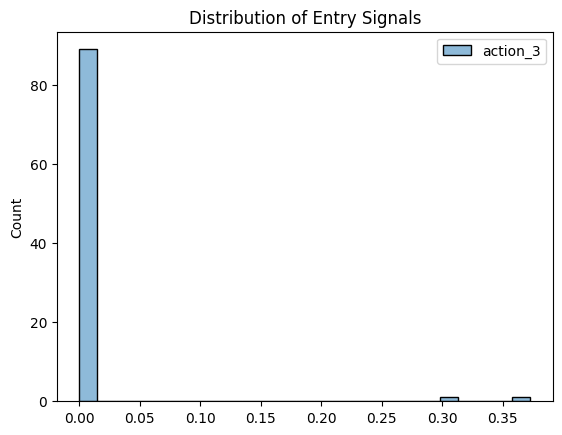

In [46]:
# plot the distribution of entry_signals
sns.histplot(entry_signals, bins=25)
plt.title('Distribution of Entry Signals')
plt.show()

In [48]:
# create a new column for entry_signals that is a 1 if the value is greater than 0.5 and 0 otherwise
sym_w_actions_n_orders.loc[:, 'entry_signal'] = np.where(sym_w_actions_n_orders['action_3'] < 0.5, 1, 0)
sym_w_actions_n_orders


,index,Time,Open,Close,Low,High,Volume,action_1,action_2,action_3,action_4,Type,Order_Volume,entry/exit,entry_signal
0,0,2024-01-02 00:00:00+00:00,1.10437,1.10439,1.10411,1.10451,375,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
1,1,2024-01-02 01:00:00+00:00,1.10441,1.10364,1.10354,1.10447,2207,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
2,2,2024-01-02 02:00:00+00:00,1.10364,1.10381,1.10340,1.10384,2376,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
3,3,2024-01-02 03:00:00+00:00,1.10380,1.10347,1.10340,1.10432,5079,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
4,4,2024-01-02 04:00:00+00:00,1.10348,1.10187,1.10180,1.10358,5520,5.000000e-01,5.000000e-01,5.000000e-01,5.000000e-01,NaN,NaN,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023,1979,2024-04-25 14:00:00+00:00,1.07247,1.07202,1.07170,1.07298,1273,1.000000e+00,1.000000e+00,4.235503e-27,1.000000e+00,NaN,NaN,NaN,1
2024,1980,2024-04-25 15:00:00+00:00,1.07202,1.07152,1.07149,1.07208,494,1.487540e-10,1.000000e+00,3.974804e-28,3.720076e-44,NaN,NaN,NaN,1
2025,1981,2024-04-25 16:00:00+00:00,1.06927,1.07006,1.06784,1.07037,3843,3.720076e-44,3.720076e-44,1.856950e-01,1.000000e+00,NaN,NaN,NaN,1
2026,1982,2024-04-25 17:00:00+00:00,1.07005,1.07118,1.06927,1.07207,3252,3.720076e-44,1.000000e+00,3.720076e-44,3.720076e-44,NaN,NaN,NaN,1


In [50]:
sym_w_actions_n_orders[sym_w_actions_n_orders['entry_signal'] == 1]

,index,Time,Open,Close,Low,High,Volume,action_1,action_2,action_3,action_4,Type,Order_Volume,entry/exit,entry_signal
9,9,2024-01-02 09:00:00+00:00,1.10286,1.10156,1.10151,1.10381,10969,1.294779e-35,3.720076e-44,7.763388e-31,3.720076e-44,Sell,100.0,Entry Time,1
10,10,2024-01-02 10:00:00+00:00,1.10156,1.10298,1.10156,1.10389,11093,1.000000e+00,3.720076e-44,5.489075e-28,1.000000e+00,Buy,100.0,Entry Time,1
11,10,2024-01-02 10:00:00+00:00,1.10156,1.10298,1.10156,1.10389,11093,1.000000e+00,3.720076e-44,5.489075e-28,1.000000e+00,Sell,100.0,Exit Time,1
12,11,2024-01-02 11:00:00+00:00,1.10298,1.10152,1.10108,1.10380,8370,9.560824e-01,1.000000e+00,3.720076e-44,1.000000e+00,Buy,100.0,Exit Time,1
13,11,2024-01-02 11:00:00+00:00,1.10298,1.10152,1.10108,1.10380,8370,9.560824e-01,1.000000e+00,3.720076e-44,1.000000e+00,Buy,100.0,Entry Time,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022,1978,2024-04-25 13:00:00+00:00,1.07267,1.07247,1.07223,1.07297,1260,3.720076e-44,1.000000e+00,3.720076e-44,3.720076e-44,NaN,NaN,NaN,1
2023,1979,2024-04-25 14:00:00+00:00,1.07247,1.07202,1.07170,1.07298,1273,1.000000e+00,1.000000e+00,4.235503e-27,1.000000e+00,NaN,NaN,NaN,1
2024,1980,2024-04-25 15:00:00+00:00,1.07202,1.07152,1.07149,1.07208,494,1.487540e-10,1.000000e+00,3.974804e-28,3.720076e-44,NaN,NaN,NaN,1
2025,1981,2024-04-25 16:00:00+00:00,1.06927,1.07006,1.06784,1.07037,3843,3.720076e-44,3.720076e-44,1.856950e-01,1.000000e+00,NaN,NaN,NaN,1


In [51]:
# save sym_w_actions_n_orders to excel
sym_w_actions_n_orders.to_csv('sym_w_actions_n_orders.csv', index=False)